In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="qwen/qwen3-32b")

In [5]:
llm = init_chat_model("groq:qwen/qwen3-32b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020489F8E480>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020489FFADB0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
def Chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [11]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",Chatbot)
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

In [12]:
graph = graph_builder.compile()

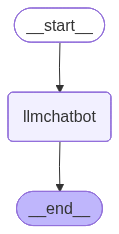

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass




In [14]:
response=graph.invoke({"messages":"Hi"})

In [15]:
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='20a8840d-91d2-4121-bace-28ab29a9697d'),
  AIMessage(content='<think>\nAlright, the user just said "Hi". Let me think about how to respond. Since they started the conversation, I should acknowledge their greeting. Maybe a friendly reply to encourage them to elaborate on what they need help with.\n\nI should check if there are any previous interactions, but since this is the start, there\'s nothing. The user might be looking for assistance with a specific problem or just testing the waters. I need to keep my response open-ended so they feel comfortable to ask anything.\n\nAlso, considering the guidelines, I should keep it helpful and concise. No need for a long message. Just a simple greeting and an offer to help with anything they need. Let me make sure the tone is welcoming and approachable.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': 

In [16]:
response["messages"][-1].content

'<think>\nAlright, the user just said "Hi". Let me think about how to respond. Since they started the conversation, I should acknowledge their greeting. Maybe a friendly reply to encourage them to elaborate on what they need help with.\n\nI should check if there are any previous interactions, but since this is the start, there\'s nothing. The user might be looking for assistance with a specific problem or just testing the waters. I need to keep my response open-ended so they feel comfortable to ask anything.\n\nAlso, considering the guidelines, I should keep it helpful and concise. No need for a long message. Just a simple greeting and an offer to help with anything they need. Let me make sure the tone is welcoming and approachable.\n</think>\n\nHello! How can I assist you today? 😊'

In [17]:
for event in graph.stream({"messages":"Hi! How are you?"}):
    print(event)

{'llmchatbot': {'messages': [AIMessage(content='<think>\nOkay, the user asked "Hi! How are you?" first. I need to respond appropriately. Since the user is greeting me and asking about my well-being, I should answer with a positive and friendly tone. I can express that I\'m fine and happy to see them, while also showing interest in their situation. The response should be concise and natural, avoiding overly complex sentences. At the same time, I should keep it open-ended to encourage further conversation, like asking how they\'re doing. This way, it fosters a more natural and engaging dialogue.\n</think>\n\nHi there! I\'m doing great, thanks for asking! I\'m always excited to chat and help out. How have you been lately? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 14, 'total_tokens': 162, 'completion_time': 0.350461469, 'prompt_time': 0.000493683, 'queue_time': 0.20293279, 'total_time': 0.350955152}, 'model_name': 'qwen/qwen3-32

In [18]:
for event in graph.stream({"messages":"Hi! How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

<think>
Okay, the user said, "Hi! How are you?" so I need to respond in a friendly and welcoming way. First, I should acknowledge their greeting and express that I'm here and ready to help. Since they asked about my well-being, I'll mention that I'm functioning well and excited to chat with them. I should also invite them to share what's on their mind or if they need assistance with anything specific. Keeping the tone positive and open-ended is important to encourage further conversation. Let me make sure the response is natural and not too robotic. Maybe add some emojis to keep it light and approachable. Alright, time to put it all together.
</think>

Hi there! 😊 I'm doing great, thanks for asking! I'm here and ready to chat, learn, or help out. How about you? What's on your mind today? 🌟


Chatbot with tool

In [6]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is Langgraph?")

{'query': 'What is Langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [7]:
##custom function with doc string
def multiply(a:int,b:int)->int:

    """ Multiply a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [8]:
tools = [tool,multiply]
llm_with_tools = llm.bind_tools(tools)

In [9]:
from langgraph.graph import StateGraph,START, END
from langgraph.prebuilt import ToolNode, tools_condition

#node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              tools_condition)
builder.add_edge("tools",END)

graph = builder.compile()




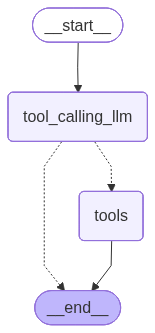

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass




In [11]:
response = graph.invoke({"messages":"What is the recent AI news?"})

In [26]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.networkworld.com/article/4076316/ai-dominates-gartners-top-strategic-technology-trends-for-2026.html", "title": "AI dominates Gartner\'s top strategic technology trends for 2026", "content": "### IBM signs up Groq for speedy AI inferencing option\\n\\n### Meta details cutting-edge networking technologies for AI infrastructure\\n\\n### Major network vendors team to advance Ethernet for scale-up AI networking\\n\\n### Cisco seriously amps-up Silicon One chip, router for AI data center connectivity\\n\\n### IBM touts agentic AI orchestration, cryptographic risk controls\\n\\n### Cisco: AI demands more reliable optical networking components\\n\\n### IBM offers AI-based cloud service to manage complex networks", "score": 0.6617704, "raw_content": null}, {"url": "https://www.dw.com/en/china-artificial-intelligence-deepseek-us-technology-semiconductors-chatgpt-graphics/a-74

In [27]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (et69y04bf)
 Call ID: et69y04bf
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.networkworld.com/article/4076316/ai-dominates-gartners-top-strategic-technology-trends-for-2026.html", "title": "AI dominates Gartner's top strategic technology trends for 2026", "content": "### IBM signs up Groq for speedy AI inferencing option\n\n### Meta details cutting-edge networking technologies for AI infrastructure\n\n### Major network vendors team to advance Ethernet for scale-up AI networking\n\n### Cisco serious

In [33]:
response = graph.invoke({"messages":"What is the 3*2 ?"})
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

What is the 3*2 ?
================================== Ai Message ==================================
Tool Calls:
  multiply (4gxe6r576)
 Call ID: 4gxe6r576
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: multiply

6


In [34]:
response = graph.invoke({"messages":"give me recent ai news and then multiply  3 and 2 ?"})
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

give me recent ai news and then multiply  3 and 2 ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a4a0w1ra1)
 Call ID: a4a0w1ra1
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
  multiply (4wzq6jf40)
 Call ID: 4wzq6jf40
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/category/artificial-intelligence/", "title": "AI News & Artificial Intelligence - TechCrunch", "content": "### European AI rising star Nexos AI raises €30M to unlock enterprise AI adoption\n\n### YC alum Cercli, an AI-powered Rippling for MENA, raises oversubscribed $12M Series A\n\nPeriodic Labs founders Ekin Dogus Cubuk (left), Liam Fedu

Adding Memory  in Agent Graph

In [13]:
from langgraph.graph import StateGraph,START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

#node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",
                              tools_condition)
builder.add_edge("tools",END)

graph = builder.compile(checkpointer=memory)




In [15]:
config = {"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi! my name is sree"}, config=config)

response["messages"][-1].content

'Hi Sree! Nice to meet you. How can I help you today?'

In [ ]:
response = graph.invoke({"messages":"Hey! do you remember me?"}, config=config)

response["messages"][-1].content

'Of course, Sree! I remember you. 😊 How can I assist you today?'

Streaming

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


In [19]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

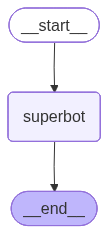

In [20]:
graph = StateGraph(State)
#node
graph.add_node("superbot",superbot)
#edges
graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

graph_builder = graph.compile(checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [25]:
config = {"configurable":{"thread_id":"2"}}
response = graph_builder.invoke({"messages":"Hey! my name is sree i like badminton"}, config=config)

response

{'messages': [HumanMessage(content='Hey! my name is sree i like badminton', additional_kwargs={}, response_metadata={}, id='7dcfc5ea-8ea4-4cc4-9360-1a40e6a6dbb8'),
  AIMessage(content="<think>\nOkay, the user introduced themselves as Sree and mentioned they like badminton. Let me start by responding warmly to their introduction. I should acknowledge their name and show enthusiasm for their interest in badminton. Next, I need to ask a follow-up question to engage them further. Maybe ask about their experience level or specific aspects of badminton they enjoy. I should keep the conversation open and friendly to encourage them to share more. Let me check if there's anything else to consider. Oh, right, I should avoid any assumptions and keep the questions general. Let me put that all together in a natural, conversational tone.\n</think>\n\nHey Sree! Nice to meet you! 🏸 I'm glad you mentioned badminton – it's such an awesome sport! Do you play recreationally or compete? I'd love to hear wh

In [26]:
config = {"configurable":{"thread_id":"3"}}
for chunk in graph_builder.stream({"messages":"Hey! my name is sree i like badminton"}, config=config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="<think>\nOkay, the user is Sree and they mentioned they like badminton. Let me start by acknowledging their name and interest. Maybe ask how they got into badminton. I should keep the tone friendly and engaging. Let them know I'm here to help with any questions or want to discuss more about badminton. Maybe suggest topics like tips for improving, local clubs, or equipment. Keep it open-ended so they feel comfortable to elaborate. Make sure the response is warm and welcoming.\n</think>\n\nHey Sree! Nice to meet you! 🏸 I love that you enjoy badminton—it's such a fun and exciting sport! Have you been playing for a while, or are you just starting out? If you ever want to discuss techniques, share cool moments from matches, or even talk about gear, I'm here for it! What aspect of badminton do you enjoy most? 🏸✨", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 190, 'prompt_tokens': 20, 'total_tokens': 210, 'completi

In [30]:
for chunk in graph_builder.stream({"messages":"Hey! my name is sree i like badminton"}, config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hey! my name is sree i like badminton', additional_kwargs={}, response_metadata={}, id='4352a784-47dc-4a69-b50f-e74ae726d4f6'), AIMessage(content="<think>\nOkay, the user is Sree and they mentioned they like badminton. Let me start by acknowledging their name and interest. Maybe ask how they got into badminton. I should keep the tone friendly and engaging. Let them know I'm here to help with any questions or want to discuss more about badminton. Maybe suggest topics like tips for improving, local clubs, or equipment. Keep it open-ended so they feel comfortable to elaborate. Make sure the response is warm and welcoming.\n</think>\n\nHey Sree! Nice to meet you! 🏸 I love that you enjoy badminton—it's such a fun and exciting sport! Have you been playing for a while, or are you just starting out? If you ever want to discuss techniques, share cool moments from matches, or even talk about gear, I'm here for it! What aspect of badminton do you enjoy most? 🏸✨

In [33]:
config = {"configurable":{"thread_id":"5"}}
async for event in graph_builder.astream_events({"messages":"Hey! how r u today? "}, config=config,stream_mode="updates"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hey! how r u today? '}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'bb283c1a-00e5-4048-a726-04b323a2e6dc', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hey! how r u today? ', additional_kwargs={}, response_metadata={}, id='9d90e731-63f8-4ea6-be87-654d311d417d')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': 'a5425d56-e129-4d54-8ccd-1ca5f5292802', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:68a6497d-ec6b-e291-4b97-bf222c5dfbb7'}, 'parent_ids': ['bb283c1a-00e5-4048-a726-04b323a2e6dc']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hey! how r u today? ', additional_kwargs={}, response_metadata={}, id='9d90e731-63f8-4ea6-b

Human in the loop